# Demo Supervised Learning

## Heart Disease Classification

In this notebook, we will try to solve the problem of classifying whether a patient will have heart disease or not using the Heart Disease Dataset and compare the specified 5 machine learning algorithms and try to justify the behaviour of each.

### About the Data

UCI - Heart Disease Dataset - https://archive.ics.uci.edu/ml/datasets/Heart+Disease

The kaggle version can be found here : https://www.kaggle.com/ronitf/heart-disease-uci 

The Heart Disease Dataset is used to solve the problem of classifying whether a patient will have heart disease or not, which is a Binary Classification problem. The data used for this assignment is obtained from Kaggle. This dataset is a processed version of the actual Cleveland database data obtained from UCI Datasets. This problem and the dataset are interesting because the dataset has multiple feature attributes (13 feature attributes) and each of these features are of different types (combination of continuous and categorical values) and the scale of the continuous values are completely different and it will be interesting to see how the Machine Learning algorithms perform on this. Also, the number of records is limited (around 303 records) and there are some outliers observed within the data. So, it will be really interesting to see how our Machine Learning Algorithms can be used to generalize on such a limited dataset with noise. And finally predicting heart disease can have real life use case and application, so that’s why I felt this would be a good problem to investigate.

### Import Modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set(style="whitegrid")

## Section 1 - Loading the data and exploratory data analysis

### Load the data

In [2]:
data = pd.read_csv("Data/heart.csv")
data.head()

age  sex  chest_pain_type  resting_bp  cholestoral  fasting_blood_sugar  \
0   63    1                3         145          233                    1   
1   37    1                2         130          250                    0   
2   41    0                1         130          204                    0   
3   56    1                1         120          236                    0   
4   57    0                0         120          354                    0   

   restecg  max_hr  exang  oldpeak  slope  num_major_vessels  thal  target  
0        0     150      0      2.3      0                  0     1       1  
1        1     187      0      3.5      0                  0     2       1  
2        0     172      0      1.4      2                  0     2       1  
3        1     178      0      0.8      2                  0     2       1  
4        1     163      1      0.6      2                  0     2       1

In [3]:
data.shape

(303, 14)

Data Distribution


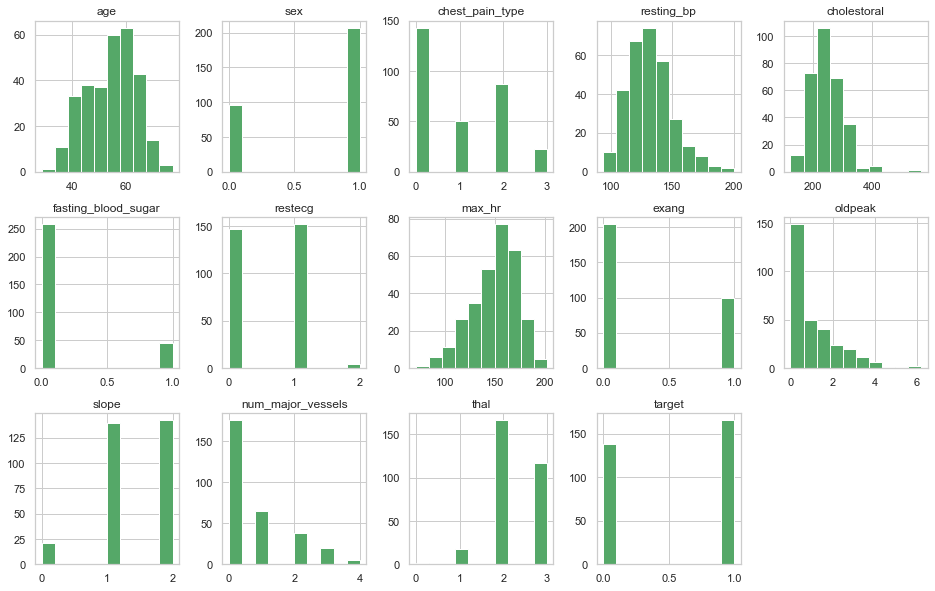

In [4]:
data.hist(layout = (3,5), figsize=(16,10), color = 'g')
print('Data Distribution')

This looks like a fairly balanced dataset, as distribution of majority and minority class is around 55:45


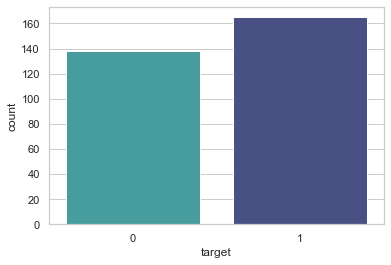

In [5]:
print('This looks like a fairly balanced dataset, as distribution of majority and minority class is around 55:45')
sns.countplot(x="target", data=data, palette="mako_r")
plt.show()

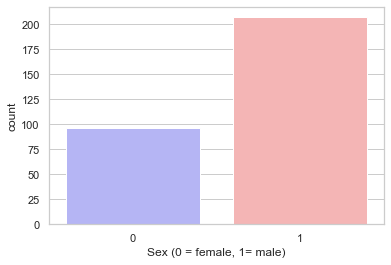

In [6]:
sns.countplot(x='sex', data=data, palette="bwr")
plt.xlabel("Sex (0 = female, 1= male)")
plt.show()

Analysing distribution of target and sex (0-female 1-male)


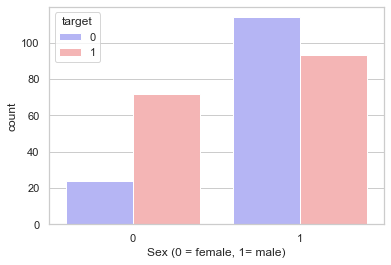

In [7]:
print('Analysing distribution of target and sex (0-female 1-male)')
sns.countplot(x = data['sex'], hue = data['target'], palette='bwr') 
plt.xlabel("Sex (0 = female, 1= male)")
plt.show()

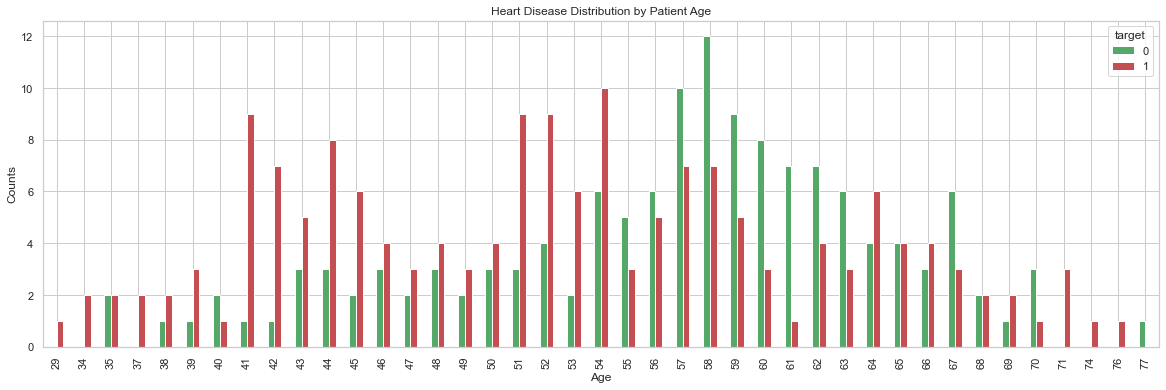

In [8]:
pd.crosstab(data.age,data.target).plot(kind="bar",figsize=(20,6), color = ['g','r'])
plt.title('Heart Disease Distribution by Patient Age')
plt.xlabel('Age')
plt.ylabel('Counts')
plt.show()

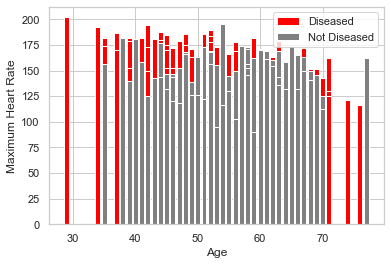

In [9]:
plt.bar(data.age[data.target==1], data.max_hr[(data.target==1)], color="red")
plt.bar(data.age[data.target==0], data.max_hr[(data.target==0)], color="grey")
plt.legend(["Diseased", "Not Diseased"])
plt.xlabel("Age")
plt.ylabel("Maximum Heart Rate")
plt.show()

## Section 2 - Data Pre-processing

In order to have a clean data for final analysis we need to pre-process the data and inspect for duplicate data, correlation, missing values, outliers, one-hot encoding for categorical values etc.

### Null or missing value check

In [10]:
data.isnull().sum()

age                    0
sex                    0
chest_pain_type        0
resting_bp             0
cholestoral            0
fasting_blood_sugar    0
restecg                0
max_hr                 0
exang                  0
oldpeak                0
slope                  0
num_major_vessels      0
thal                   0
target                 0
dtype: int64

We do not see any missing values for this dataset.

### Duplicate inspection

In [11]:
data.duplicated().any()

True

Looks like the dataset has some duplicates. Let's remove the duplicates

In [12]:
data.drop_duplicates(subset=None, inplace=True)
data.duplicated().any()

False

In [13]:
data.shape

(302, 14)

So, we can see that there was one duplicate row

### One Hot Encoding

Since we have many categorical values withn the data, we would need to do one-hot encoding to convert the categorical values to discrete real values for a better noise-free analysis

In [14]:
def encode_features(df, features):
    '''
    Method for one-hot encoding all selected categorical fields
    '''
    for f in features:
        if(f in df.columns):
            encoded = pd.get_dummies(df[f])
            encoded = encoded.add_prefix(f + '_')
            df = pd.concat([df, encoded], axis=1)
        else:
            print('Feature not found')
            return df
        
    df.drop(columns=features, inplace = True)
    
    return df

In [15]:
features_to_encode = ['thal', 'slope', 'chest_pain_type', 'restecg']
encoded = encode_features(data, features_to_encode)
data = encoded.copy()
print(data.shape)

(302, 24)


In [16]:
data.columns

Index(['age', 'sex', 'resting_bp', 'cholestoral', 'fasting_blood_sugar',
       'max_hr', 'exang', 'oldpeak', 'num_major_vessels', 'target', 'thal_0',
       'thal_1', 'thal_2', 'thal_3', 'slope_0', 'slope_1', 'slope_2',
       'chest_pain_type_0', 'chest_pain_type_1', 'chest_pain_type_2',
       'chest_pain_type_3', 'restecg_0', 'restecg_1', 'restecg_2'],
      dtype='object')

After one hot encoding we see that 14 new columns are added and the 4 categorical columns are dropped

### Outlier Inspection

In [17]:
data.describe()

age         sex  resting_bp  cholestoral  fasting_blood_sugar  \
count  302.00000  302.000000  302.000000   302.000000           302.000000   
mean    54.42053    0.682119  131.602649   246.500000             0.149007   
std      9.04797    0.466426   17.563394    51.753489             0.356686   
min     29.00000    0.000000   94.000000   126.000000             0.000000   
25%     48.00000    0.000000  120.000000   211.000000             0.000000   
50%     55.50000    1.000000  130.000000   240.500000             0.000000   
75%     61.00000    1.000000  140.000000   274.750000             0.000000   
max     77.00000    1.000000  200.000000   564.000000             1.000000   

           max_hr       exang     oldpeak  num_major_vessels      target  ...  \
count  302.000000  302.000000  302.000000         302.000000  302.000000  ...   
mean   149.569536    0.327815    1.043046           0.718543    0.543046  ...   
std     22.903527    0.470196    1.161452           1.006748    0.498970  ...   
min     71.000000    0.000000    0.000000           0.000000    0.000000  ...   
25%    133.250000    0.000000    0.000000           0.000000    0.000000  ...   
50%    152.500000    0.000000    0.800000           0.000000    1.000000  ...   
75%    166.000000    1.000000    1.600000           1.000000    1.000000  ...   
max    202.000000    1.000000    6.200000           4.000000    1.000000  ...   

          slope_0     slope_1     slope_2  chest_pain_type_0  \
count  302.000000  302.000000  302.000000         302.000000   
mean     0.069536    0.463576    0.466887           0.473510   
std      0.254786    0.499499    0.499730           0.500126   
min      0.000000    0.000000    0.000000           0.000000   
25%      0.000000    0.000000    0.000000           0.000000   
50%      0.000000    0.000000    0.000000           0.000000   
75%      0.000000    1.000000    1.000000           1.000000   
max      1.000000    1.000000    1.000000           1.000000   

       chest_pain_type_1  chest_pain_type_2  chest_pain_type_3   restecg_0  \
count         302.000000         302.000000         302.000000  302.000000   
mean            0.165563           0.284768           0.076159    0.486755   
std             0.372305           0.452053           0.265693    0.500654   
min             0.000000           0.000000           0.000000    0.000000   
25%             0.000000           0.000000           0.000000    0.000000   
50%             0.000000           0.000000           0.000000    0.000000   
75%             0.000000           1.000000           0.000000    1.000000   
max             1.000000           1.000000           1.000000    1.000000   

       restecg_1   restecg_2  
count  302.00000  302.000000  
mean     0.50000    0.013245  
std      0.50083    0.114512  
min      0.00000    0.000000  
25%      0.00000    0.000000  
50%      0.50000    0.000000  
75%      1.00000    0.000000  
max      1.00000    1.000000  

[8 rows x 24 columns]

From manual inspection, we do see that for cholestoral and oldpeak we may have some outliers

### Data Correlation

age                   -0.221476
sex                   -0.283609
resting_bp            -0.146269
cholestoral           -0.081437
fasting_blood_sugar   -0.026826
max_hr                 0.419955
exang                 -0.435601
oldpeak               -0.429146
num_major_vessels     -0.408992
target                 1.000000
thal_0                -0.007056
thal_1                -0.105986
thal_2                 0.526030
thal_3                -0.484887
slope_0               -0.062822
slope_1               -0.360258
slope_2                0.392121
chest_pain_type_0     -0.514626
chest_pain_type_1      0.247649
chest_pain_type_2      0.313696
chest_pain_type_3      0.087959
restecg_0             -0.157299
restecg_1              0.172827
restecg_2             -0.068156
Name: target, dtype: float64


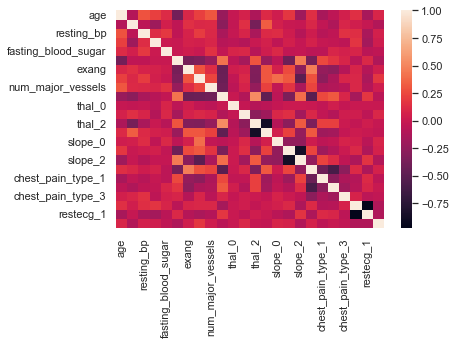

In [18]:
print(data.corr()['target'])
sns.heatmap(data.corr())
plt.show()

It is observed that the features does not have a strong correlation (>0.6) with the target. Otherwise correlated or inversely correlated values had to be removed to remove any additional training bias

## Section -3 : Feature Engineering

In this step we will remove outliers on non categorical fields using Nelson's 1st rule and normalize the data for a better model generalization and efficiency.

In [19]:
feature_engg_data = data.copy()
outlier_data = data.copy()
target_index = data.columns.get_loc("target") # Use this for separating the target labels from data
factor = 3
# Include this only for columns with suspected outliers
# Using a factor of 3, following Nelson's rule 1 to remove outliers - https://en.wikipedia.org/wiki/Nelson_rules
# Only for non-categorical fields
columns_to_include = ['age', 'resting_bp', 'cholestoral', 'max_hr', 'oldpeak', 'num_major_vessels']
for column in columns_to_include:
    upper_lim = feature_engg_data[column].mean () + feature_engg_data[column].std () * factor
    lower_lim = feature_engg_data[column].mean () - feature_engg_data[column].std () * factor
    feature_engg_data = feature_engg_data[(feature_engg_data[column] < upper_lim) & (feature_engg_data[column] > lower_lim)]
    
outlier_data = pd.concat([outlier_data, feature_engg_data]).drop_duplicates(keep=False)

In [20]:
print(feature_engg_data.shape)
print(outlier_data.shape)

(289, 24)
(13, 24)


In the following section in-order to build the model, we will need to normalize the data and split the data into train, validation and test dataset. The outlier data that we have, we will keep it separate, just in case to see how does our model performs on the outlier dataset.

#### Data Normalization

In [21]:
from sklearn import preprocessing

def normalize_data(df):
    val = df.values 
    min_max_normalizer = preprocessing.MinMaxScaler()
    norm_val = min_max_normalizer.fit_transform(val)
    df2 = pd.DataFrame(norm_val)
    
    return df2

norm_feature_engg_data = normalize_data(feature_engg_data)
norm_outlier_data = normalize_data(outlier_data)

In [22]:
norm_feature_engg_data = normalize_data(feature_engg_data)
norm_outlier_data = normalize_data(outlier_data)

#### Data Splits

Splitting Feature Engineered Data into train-valid-test dataset in 70:20:10 Ratio, the choice of selecting this splitting ratio is to ensure we have sufficient training data, sufficient validation data for mainly hyper parameter tuning and sufficient testing data to ensure model generalization.

In [23]:
from sklearn.model_selection import train_test_split

input_data = norm_feature_engg_data.drop([target_index],axis='columns')
targets =norm_feature_engg_data.filter([target_index],axis='columns')

x, x_test, y, y_test = train_test_split(input_data,targets,test_size=0.1,train_size=0.9, random_state=5)
x_train, x_valid, y_train, y_valid = train_test_split(x,y,test_size = 0.22,train_size =0.78, random_state=5)

## Section 4 -  Building the Model

#### Model Evaluation Metrics

For model evaluation we will use AUC-ROC Scores, Accuracy and Confusion matrix to see how well the model is generalized and efficient on mainly validation and test sets. But these metric will be initially used on the test set to see how well the model fits on the training data and is there any significant bias on the training set.

In [24]:
from sklearn.metrics import accuracy_score,roc_auc_score,confusion_matrix
import math
import seaborn as sns

def evaluatation_metrics(y_true, y_pred,model):
    
    accuracy = accuracy_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred, average='weighted')
    cm = confusion_matrix(y_true, y_pred)

    print("Accuracy of",model,": {:.2f}".format(accuracy))
    print("ROC AUC Score of", model,": {:.2f}".format(roc_auc))
    print("Confusion Matrix of", model,": \n")
    
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    title = 'AUC-ROC Score: {:.2f}'.format(roc_auc)
    plt.title(title)
    plt.show()

In [25]:
import time

def ml_model(classifier, classifier_name, **kwargs):
    '''
    Generic method to train the selected classification algorithm on train, validation and test dataset.
    '''
    # Fit model
    if kwargs['x_train'] is not None:
        model = classifier.fit(kwargs['x_train'], kwargs['y_train'])
        y_pred_train= model.predict(kwargs['x_train'])
        print('*****************************************************')
        print('Training Set Performance:')
        print('*****************************************************')
        evaluatation_metrics(kwargs['y_train'], y_pred_train, classifier_name)
    
    if kwargs['x_valid'] is not None:
        y_pred_valid = model.predict(kwargs['x_valid'])
        print('*****************************************************')
        print('Validation Set Performance:')
        print('*****************************************************')
        evaluatation_metrics(kwargs['y_valid'], y_pred_valid, classifier_name)
    
    if kwargs['x_test'] is not None:
        start = time.time()
        y_pred_test= classifier.predict(kwargs['x_test'])
        end = time.time()
        print('*****************************************************')
        print('Test Set Performance:')
        print('*****************************************************')
        print('Model Time Complexity on Test Data: {:.3f} milli seconds'.format((end - start) * 1000))
        evaluatation_metrics(kwargs['y_test'], y_pred_test, classifier_name)

In [26]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curves(train_sizes, train_scores_mean, train_scores_std, test_scores_mean, test_scores_std, model_name):
    '''
    Method to generate learning curves for using training and cross validation scores
    '''
    plt.title(model_name)

    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",label="Cross-validation score")
    plt.legend(loc="best")
    plt.show()

def plot_model_scalability_curves(train_sizes, training_time_mean, training_time_std, model_name):
    '''
    Method to generate scalability curve to see the model complexity
    '''
    plt.plot(train_sizes, training_time_mean, 'o-', color = 'purple')
    plt.fill_between(train_sizes, training_time_mean - training_time_std,
                         training_time_mean + training_time_std, alpha=0.1, color = 'purple')
    plt.xlabel("Training examples")
    plt.ylabel("Training time")
    plt.title("Scalability of "+ model_name)
    plt.show()

def plot_model_performance_curves(training_time_mean, test_scores_mean, test_scores_std, model_name):
    '''
    Method to generate performance curves to see if increase model complexity would improve score or not
    '''
    plt.plot(training_time_mean, test_scores_mean, 'o-')
    plt.fill_between(training_time_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    plt.xlabel("Training Time")
    plt.ylabel("Score")
    plt.title("Performance of "+ model_name)
    plt.show()


def generate_learning_curves(model, model_name, X, y, xlim = None, ylim=None, 
                         epochs =None, figsize = (20,5)):
    '''
    Generic method to generate Learning Curves, Scalability curves and Performance curves
    Referred - https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py 
    '''
    cross_valid = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
    
    train_sizes=np.linspace(.1, 1.0, 5)
    train_sizes, train_scores, test_scores, training_time, _ = learning_curve(model, X, y, cv=cross_valid, 
                                                                           n_jobs=epochs, train_sizes=train_sizes,
                                                                           return_times=True)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    training_time_mean = np.mean(training_time, axis=1)
    training_time_std = np.std(training_time, axis=1)

    # Plot learning curve
    plot_learning_curves(train_sizes, train_scores_mean, train_scores_std, test_scores_mean, test_scores_std, model_name)

    # Plot scalability curve
    plot_model_scalability_curves(train_sizes, training_time_mean, training_time_std, model_name)

    # Plot model performance score
    plot_model_performance_curves(training_time_mean, test_scores_mean, test_scores_std, model_name)

### Classification Algorithms

#### Baseline -  Decision Tree

*****************************************************
Training Set Performance:
*****************************************************
Accuracy of Decision Tree : 1.00
ROC AUC Score of Decision Tree : 1.00
Confusion Matrix of Decision Tree : 



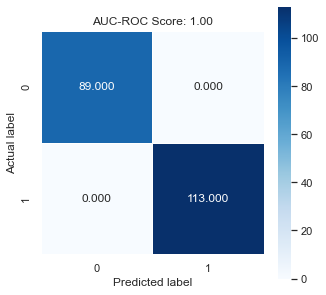

*****************************************************
Validation Set Performance:
*****************************************************
Accuracy of Decision Tree : 0.71
ROC AUC Score of Decision Tree : 0.71
Confusion Matrix of Decision Tree : 



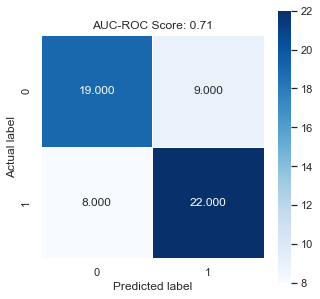

In [27]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

DTC = DecisionTreeClassifier(criterion='entropy', random_state=3) # Baseline model without any form of pruning
ml_model(DTC, 'Decision Tree', x_train = x_train, y_train = y_train, x_valid = x_valid, y_valid = y_valid, x_test = None)

We see how poorly the baseline decision tree model performs on the validation set. This is due to very high over-fitting on training data. The overfitting is happening for both Gini Index and Entropy.
Gini index operates on the categorical target variables in terms of “true” and “false” and performs only binary split, in opposite to that Information Gain computes the difference between entropy before and after the split and indicates the impurity in classes of elements.

In [ ]:
# Visualizing Decision Trees
fig, axes = plt.subplots(figsize = (12,10), dpi=500)
plot_tree(DTC,filled = True)
plt.show()

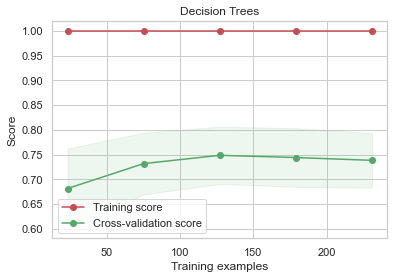

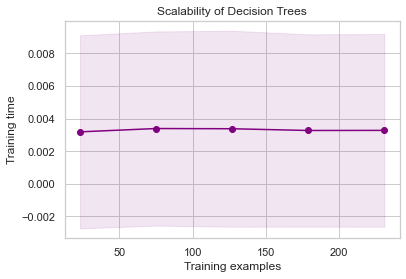

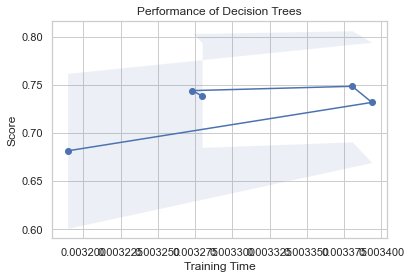

In [28]:
# Generation model curves on training and cross validation data
generate_learning_curves(
    model = DTC, 
    model_name = "Decision Trees", 
    X = input_data,
    y = targets,
    ylim=(0.7, 1.01),
    epochs=5)

These curves are showing presence of high overfiting on basseline model, but the model time may be almost constan, hence almost constant time complexity, but the performance curve shows no significant improvment with more training time and training samples.

#### Hyper-parameter tuning

In this step, we will do post pruning to find the best parameter values for maximum depth of the tree and minimum leaf samples for the decision tree, so as to prevent it from over-fitting and generalizing the model. First we will use Grid Search to short list initial hyper parameter values.

In [29]:
from sklearn.model_selection import GridSearchCV

In [30]:
# We will apply grid search to find the best possible set of hyper parameters
def DTGridSearch(X,y,param_lim):
    '''
    Decision Tree Grid Search to find the initial best guess of hyper-parameters
    '''
    param_grid = {
                    'min_samples_leaf':np.linspace(param_lim[0],param_lim[1],20).astype('int'), 
                    'max_depth':np.arange(1,param_lim[2]),
                    'criterion' : ['entropy' , 'gini']
    }

    best_DT = GridSearchCV(estimator = DecisionTreeClassifier(random_state=3), param_grid=param_grid, cv=10)
    best_DT.fit(X, y)
    
    print("Best Decision Tree Hyper-Parameters are:")
    print(best_DT.best_params_)
    
    return best_DT.best_params_['min_samples_leaf'], best_DT.best_params_['max_depth'], best_DT.best_params_['criterion']

In [31]:
min_samples_leaf_lim = int(0.005 * len(x_train)) # 0.5% of length of training size
max_samples_leaf_lim = int(0.1 * len(x_train)) # 10% of length of training size
max_depth = 10

best_min_sample_leaf, best_max_depth, best_criterion = DTGridSearch( x_train,
                                                                     y_train,
                                                                     (min_samples_leaf_lim, max_samples_leaf_lim, max_depth)
                                                                   )

Best Decision Tree Hyper-Parameters are:
{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 12}


Now, although grid search is done on training set, in-order to check the generalization, we would iterate with various depth of the tree on both training and validation dataset, and pickup the best depth (one with lowest error rate) and consider that as the final version of the best parameters.

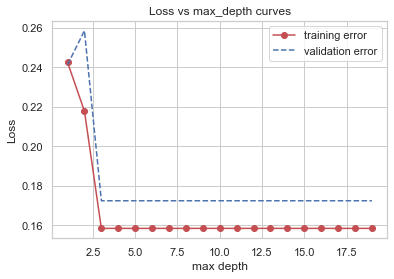

In [32]:
train=[]
valid=[]
for i in range(1,20):
    dec = DecisionTreeClassifier(criterion = 'gini', min_samples_leaf = 12, random_state=3, max_depth=i)
    dec.fit(x_train, y_train)
    train.append(1- accuracy_score(dec.predict(x_train), y_train))
    valid.append(1- accuracy_score(dec.predict(x_valid), y_valid))

plt.title('Loss vs max_depth curves')
depth=[i for i in range(1,20)]
plt.plot(depth,train,'o-', color = 'r', label = 'training error')
plt.plot(depth,valid, '--', color = 'b', label = 'validation error')
plt.xlabel('max depth')
plt.ylabel('Loss')
plt.legend()

The loss curve also shows some over-fitting, but the lowest loss is obtained for a max_depth = 3. Now, let's apply these hyper-parameter values and let's see the model performance and generalization.

*****************************************************
Training Set Performance:
*****************************************************
Accuracy of Decision Tree : 0.84
ROC AUC Score of Decision Tree : 0.84
Confusion Matrix of Decision Tree : 



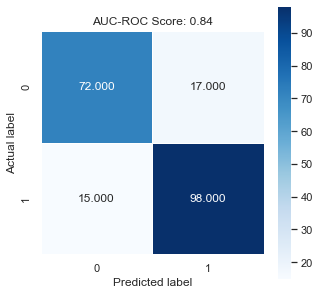

*****************************************************
Validation Set Performance:
*****************************************************
Accuracy of Decision Tree : 0.83
ROC AUC Score of Decision Tree : 0.83
Confusion Matrix of Decision Tree : 



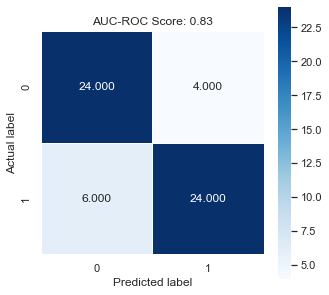

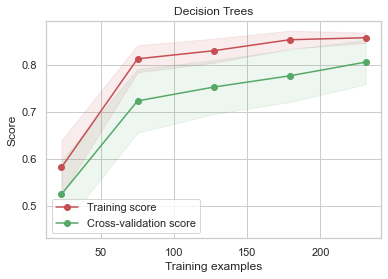

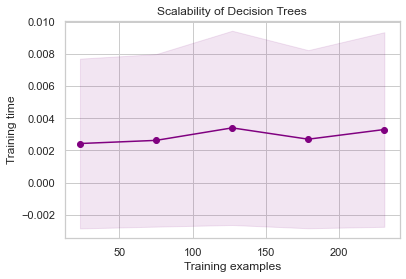

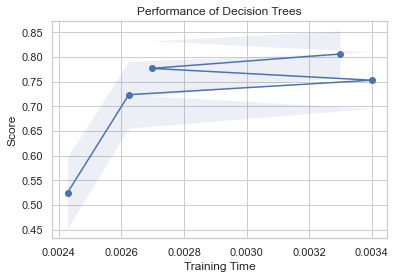

In [33]:
tuned_DTC = DecisionTreeClassifier(criterion='gini', max_depth = 3, min_samples_leaf = 12, random_state=3)
ml_model(tuned_DTC, 'Decision Tree', x_train = x_train, y_train = y_train, x_valid = x_valid, y_valid = y_valid, x_test = None)

generate_learning_curves(
    model = tuned_DTC, 
    model_name = "Decision Trees", 
    X = input_data,
    y = targets,
    ylim=(0.7, 1.01),
    epochs=5)

The tuned decision tree does show significant improvement in model performance, with an inrease in AUC-ROC score by 12% and is very well generalized as no significant over-fitting, but we can say that the model has some bias and hence it might be under-fitting. But the hyper-parameter tuning process was successful as we see performance improvment from baseline model.

#### Baseline - Neural Networks

*****************************************************
Training Set Performance:
*****************************************************
Accuracy of Neural Network : 0.85
ROC AUC Score of Neural Network : 0.85
Confusion Matrix of Neural Network : 



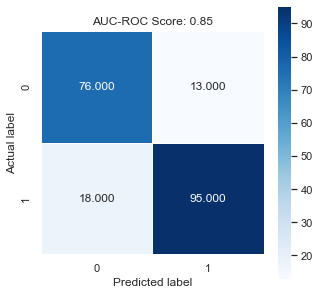

*****************************************************
Validation Set Performance:
*****************************************************
Accuracy of Neural Network : 0.79
ROC AUC Score of Neural Network : 0.79
Confusion Matrix of Neural Network : 



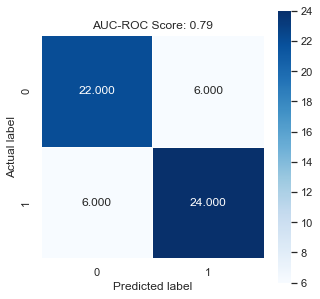

In [34]:
from sklearn.neural_network import MLPClassifier

NN = MLPClassifier(hidden_layer_sizes=50, solver='adam', activation='relu', learning_rate_init=0.05,  random_state=0)
ml_model(NN, 'Neural Network', x_train = x_train, y_train = y_train.values.ravel(), x_valid = x_valid, y_valid = y_valid.values.ravel(), x_test = None)

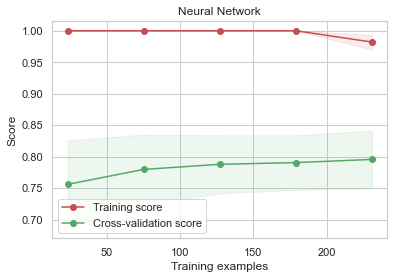

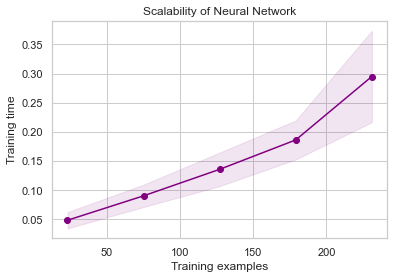

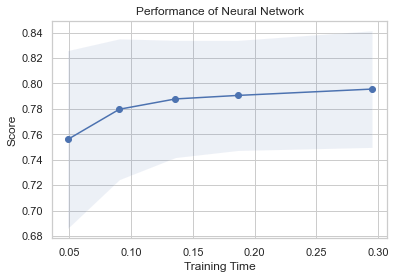

In [35]:
generate_learning_curves(
    model = NN, 
    model_name = "Neural Network", 
    X = input_data,
    y = targets,
    ylim=(0.7, 1.01),
    epochs=10)

These curves are showing presence of high overfiting on basseline model, but the scalability curve shows almost linear time complexity, but the performance curve shows no significant improvment with more training time and training samples.

#### Hyper-parameter tuning

Like the Decision Trees algorithms first we will apply grid search to find the best possible set of hyper parameters and then using the loss curves we will select the final set of hyper-parameters. For the neural nets, we will tune the number of hidden layers which controls the model complexity (increasing this may make the model performance more efficient but make the model slow to process), and learning rate, tuning it determines the model convergence.

In [36]:
def NNGridSearch(X, y, param_limits):
    '''
    Enural Network Grid Search
    ''' 
    param_grid = {
                  'hidden_layer_sizes': param_limits[0],
                  'learning_rate_init': param_limits[1]
                 }

    best_nn = GridSearchCV(
                           estimator = MLPClassifier(solver='adam',activation='relu',random_state=0),
                           param_grid=param_grid, 
                           cv=10
                          )
    best_nn.fit(X, y)
    
    print("Best Decision Tree Hyper-Parameters are:")
    print(best_nn.best_params_)
    
    return best_nn.best_params_['hidden_layer_sizes'], best_nn.best_params_['learning_rate_init']

In [37]:
hidden_units = list(range(10,100,10))
lr = [0.05, 0.1]

best_hidden_unit, best_lr = NNGridSearch(x_train,  y_train.values.ravel(), (hidden_units, lr))

d:\pd\engagements\upgrad\sessions\docker+fastapi\deployment\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
d:\pd\engagements\upgrad\sessions\docker+fastapi\deployment\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
d:\pd\engagements\upgrad\sessions\docker+fastapi\deployment\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
d:\pd\engagements\upgrad\sessions\docker+fastapi\deployment\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum it

Best Decision Tree Hyper-Parameters are:
{'hidden_layer_sizes': 80, 'learning_rate_init': 0.05}


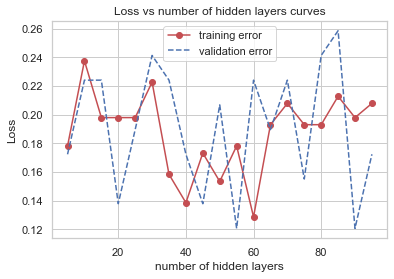

In [38]:
train=[]
valid=[]
for i in range(5,100,5):
    nn = MLPClassifier(hidden_layer_sizes=i, solver='adam', activation='relu', learning_rate_init = best_lr, random_state=0)
    nn.fit(x_train, y_train.values.ravel())
    train.append(1- accuracy_score(nn.predict(x_train), y_train.values.ravel()))
    valid.append(1- accuracy_score(nn.predict(x_valid), y_valid.values.ravel()))

plt.title('Loss vs number of hidden layers curves')
hidden_layers=[i for i in range(5,100,5)]
plt.plot(hidden_layers, train,'o-', color = 'r', label = 'training error')
plt.plot(hidden_layers, valid, '--', color = 'b', label = 'validation error')
plt.xlabel('number of hidden layers')
plt.ylabel('Loss')
plt.legend()
plt.show()

From the loss curve above, we can see that the lowest validation loss is observed for number of hidden units = 55. Now let's see the tuned model performance with these selected best set of hyper-parameters. But the loss curves does show some instability or randomness of the model.

*****************************************************
Training Set Performance:
*****************************************************
Accuracy of Neural Network : 0.82
ROC AUC Score of Neural Network : 0.81
Confusion Matrix of Neural Network : 



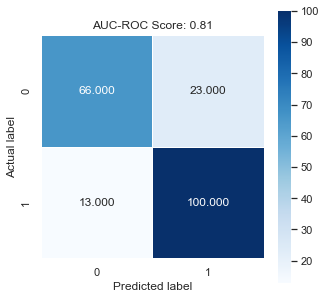

*****************************************************
Validation Set Performance:
*****************************************************
Accuracy of Neural Network : 0.88
ROC AUC Score of Neural Network : 0.88
Confusion Matrix of Neural Network : 



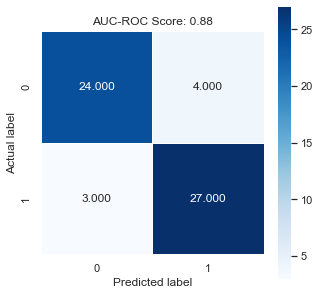

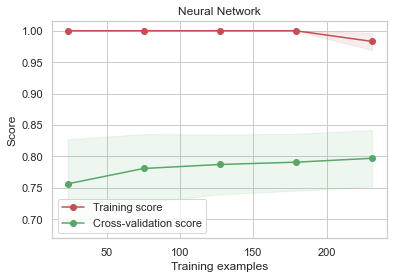

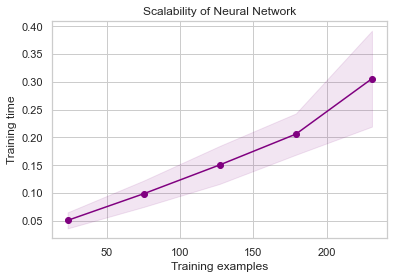

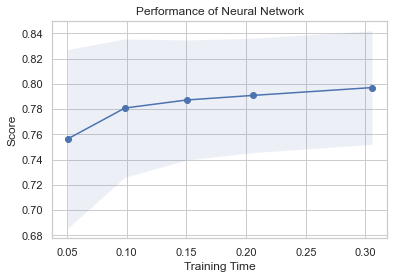

In [39]:
tuned_NN = MLPClassifier(hidden_layer_sizes=55, solver='adam', activation='relu', learning_rate_init=0.05, random_state = 0)
ml_model(tuned_NN, 'Neural Network', x_train = x_train, y_train = y_train.values.ravel(), x_valid = x_valid, y_valid = y_valid.values.ravel(), x_test = None)

generate_learning_curves(
    model = tuned_NN, 
    model_name = "Neural Network", 
    X = input_data,
    y = targets,
    ylim=(0.7, 1.01),
    epochs=10)

The model evaluation metrics show some good improvement over the baseline model but the model curves of the tuned and untuned model looks similar.
MLP Neural Networks are extremely unstable and even the loss curves show the same thing. The hyper-parameter tuning process does show improvement in model scores by 9% on validation set, which no over-fitting but slight under-fitting as the model might have some bias. The tuned model is generalized but may not be reliable as we see from the model curve nature.

#### Baseline - ADABoost

*****************************************************
Training Set Performance:
*****************************************************
Accuracy of ADABoost : 0.95
ROC AUC Score of ADABoost : 0.94
Confusion Matrix of ADABoost : 



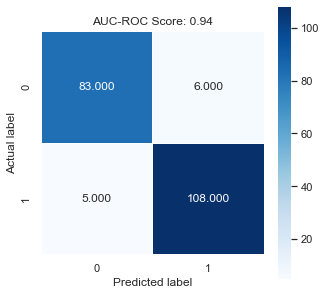

*****************************************************
Validation Set Performance:
*****************************************************
Accuracy of ADABoost : 0.76
ROC AUC Score of ADABoost : 0.75
Confusion Matrix of ADABoost : 



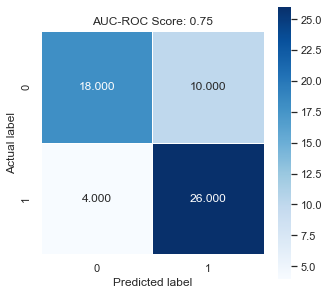

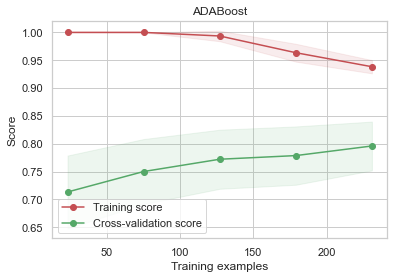

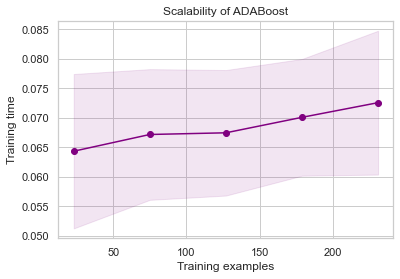

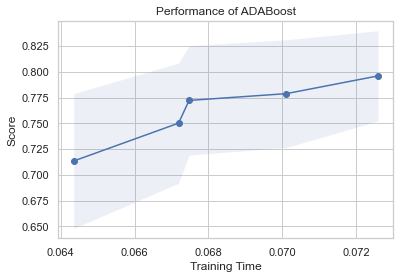

In [40]:
from sklearn.ensemble import AdaBoostClassifier
adaBoost = AdaBoostClassifier(random_state=7)

ml_model(adaBoost, 'ADABoost', x_train = x_train, x_valid = x_valid, y_train =  y_train.values.ravel(), y_valid = y_valid.values.ravel(), x_test = None)

generate_learning_curves(
    model = adaBoost, 
    model_name = "ADABoost", 
    X = input_data,
    y = targets,
    epochs=4)

#### Hyper-parameter tuning

In [41]:
def ABGridSearch(X, y, param_limits):
    '''
    Grid Search for ADABoost
    ''' 
    param_grid = {
                  'n_estimators': param_limits[0],
                  'learning_rate': param_limits[1],
                  'algorithm' : param_limits[2]
                 }

    best_adb = GridSearchCV(
                           estimator = AdaBoostClassifier(random_state=7),
                           param_grid=param_grid, 
                           cv=10
                          )
    best_adb.fit(X, y)
    
    print("Best Decision Tree Hyper-Parameters are:")
    print(best_adb.best_params_)
    
    return best_adb.best_params_['n_estimators'], best_adb.best_params_['learning_rate'], best_adb.best_params_['algorithm']

In [42]:
n_estimators = list(range(10,100,10))
learning_rate = [0.05, 0.1, 0.5, 1.0]
algorithm = ['SAMME', 'SAMME.R']
best_n_estimators, best_lr, best_algo = ABGridSearch(x_train,  y_train.values.ravel(), (n_estimators, learning_rate, algorithm))

Best Decision Tree Hyper-Parameters are:
{'algorithm': 'SAMME', 'learning_rate': 0.1, 'n_estimators': 90}


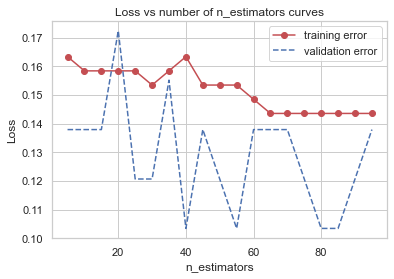

In [43]:
train=[]
valid=[]
for i in range(5,100,5):
    adaBoost = AdaBoostClassifier(n_estimators=i, algorithm = best_algo, learning_rate = best_lr, random_state=7)
    adaBoost.fit(x_train, y_train.values.ravel())
    train.append(1- accuracy_score(adaBoost.predict(x_train), y_train.values.ravel()))
    valid.append(1- accuracy_score(adaBoost.predict(x_valid), y_valid.values.ravel()))

plt.title('Loss vs number of n_estimators curves')
num_estimators=[i for i in range(5,100,5)]
plt.plot(num_estimators, train,'o-', color = 'r', label = 'training error')
plt.plot(num_estimators, valid, '--', color = 'b', label = 'validation error')
plt.xlabel('n_estimators')
plt.ylabel('Loss')
plt.legend()
plt.show()

best n estimator from loss curves = 40, but more the number of estimators, the model performance would be slow

*****************************************************
Training Set Performance:
*****************************************************
Accuracy of ADABoost : 0.84
ROC AUC Score of ADABoost : 0.83
Confusion Matrix of ADABoost : 



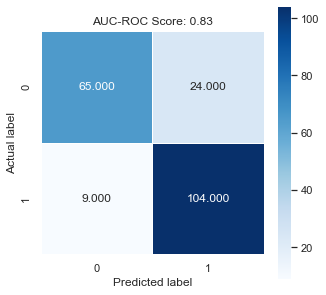

*****************************************************
Validation Set Performance:
*****************************************************
Accuracy of ADABoost : 0.90
ROC AUC Score of ADABoost : 0.89
Confusion Matrix of ADABoost : 



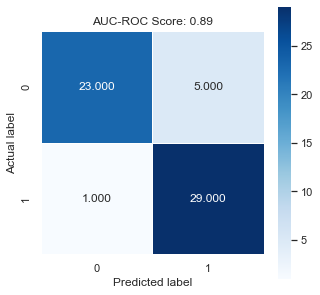

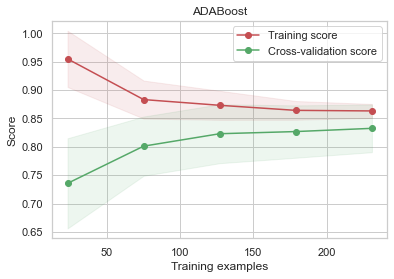

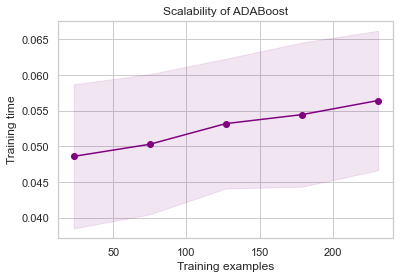

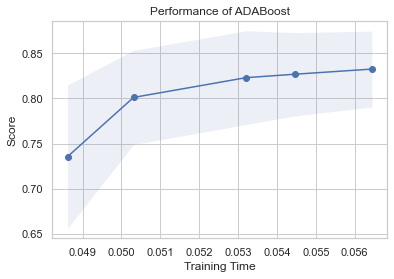

In [44]:
tuned_adaBoost = AdaBoostClassifier(n_estimators=40, algorithm = best_algo, learning_rate = best_lr, random_state=7)

ml_model(tuned_adaBoost, 'ADABoost', x_train = x_train, x_valid = x_valid, y_train =  y_train.values.ravel(), y_valid = y_valid.values.ravel(), x_test = None)

generate_learning_curves(
    model = tuned_adaBoost, 
    model_name = "ADABoost", 
    X = input_data,
    y = targets,
    epochs=4)

significant improvment in model performance after hyper parameter tuning. Almost 14% improvement, with no significant over-fitting and very minimal bias. So, this appears to be a really good fit, the model performance on the test data can be good as the model appears to be generalized.

#### Baseline - Support Vector Machines

*****************************************************
Training Set Performance:
*****************************************************
Accuracy of SVM : 0.88
ROC AUC Score of SVM : 0.87
Confusion Matrix of SVM : 



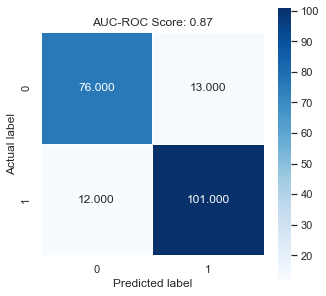

*****************************************************
Validation Set Performance:
*****************************************************
Accuracy of SVM : 0.79
ROC AUC Score of SVM : 0.79
Confusion Matrix of SVM : 



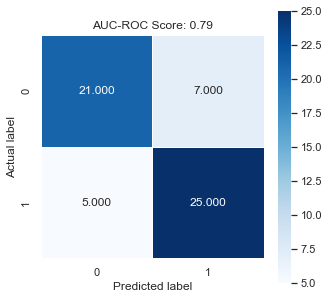

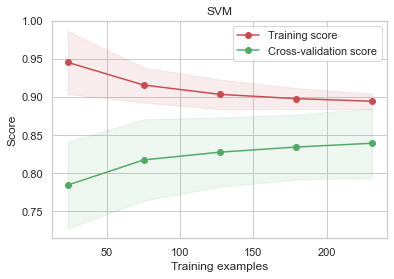

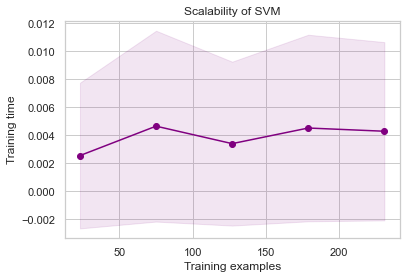

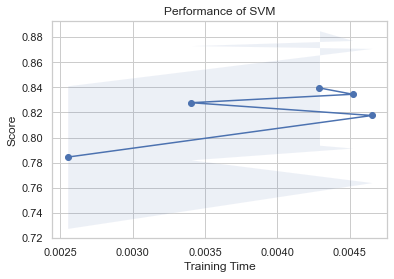

In [45]:
from sklearn import svm
svc = svm.SVC(kernel = "rbf", random_state = 3)

ml_model(svc, 'SVM', x_train = x_train, x_valid = x_valid, y_train =  y_train.values.ravel(), y_valid = y_valid.values.ravel(), x_test = None)

generate_learning_curves(
    model = svc, 
    model_name = "SVM", 
    X = input_data,
    y = targets,
    epochs=4)

#### Hyper-parameter tuning

In [46]:
def SVMGridSearch(X, y, param_limits):
    '''
    SVM Grid Search
    '''    
    param_grid = {
                  'C': param_limits[0],
                  'gamma': param_limits[1],
                  'kernel': param_limits[2]
                 }

    svc = GridSearchCV(estimator = svm.SVC(random_state = 3),
                       param_grid=param_grid, 
                       cv=10)
    
    svc.fit(X, y)
    print("Best SVM Hyper-Parameters are:")
    print(svc.best_params_)
    
    return svc.best_params_['C'], svc.best_params_['gamma'], svc.best_params_['kernel']

In [47]:
C = [0.0001, 0.001, 0.01, 0.1, 1.0, 5.0, 10.0]
gammas = [1,10,100]
kernel = ['linear','poly','rbf','sigmoid']

best_C, best_gamma, best_kernel = SVMGridSearch(x_train,  y_train.values.ravel(), (C, gammas, kernel))

Best SVM Hyper-Parameters are:
{'C': 0.01, 'gamma': 1, 'kernel': 'linear'}


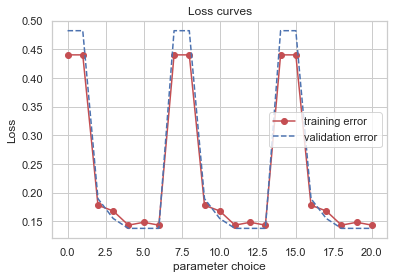

In [48]:
train=[]
valid=[]
best_hyper_params = []
for g in gammas:
    for c in C:
        svc = svm.SVC(kernel = "linear", C=c, gamma = g, random_state = 3)
        svc.fit(x_train, y_train.values.ravel())
        train.append(1- accuracy_score(svc.predict(x_train), y_train.values.ravel()))
        valid.append(1- accuracy_score(svc.predict(x_valid), y_valid.values.ravel()))
        best_hyper_params.append((c,g))

plt.title('Loss curves')
num_estimators= list(range(len(train)))
plt.plot(num_estimators, train,'o-', color = 'r', label = 'training error')
plt.plot(num_estimators, valid, '--', color = 'b', label = 'validation error')
plt.xlabel('parameter choice')
plt.ylabel('Loss')
plt.legend()
plt.show()

*****************************************************
Training Set Performance:
*****************************************************
Accuracy of SVM : 0.86
ROC AUC Score of SVM : 0.85
Confusion Matrix of SVM : 



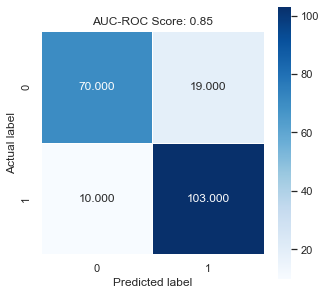

*****************************************************
Validation Set Performance:
*****************************************************
Accuracy of SVM : 0.86
ROC AUC Score of SVM : 0.86
Confusion Matrix of SVM : 



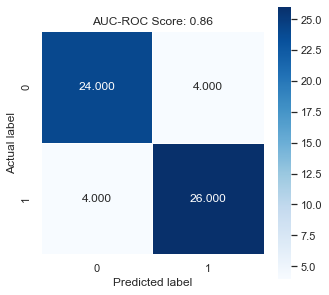

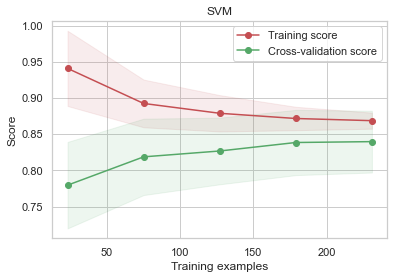

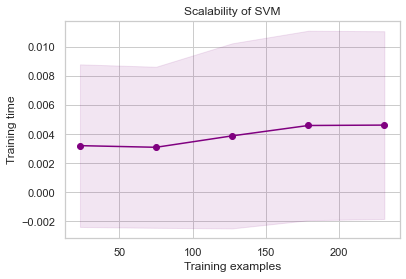

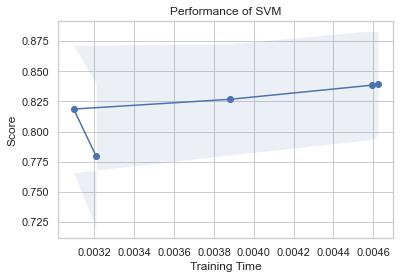

In [49]:
tuned_svc = svm.SVC(kernel = "linear", C=1, gamma = 1, random_state = 3)

ml_model(tuned_svc, 'SVM', x_train = x_train, x_valid = x_valid, y_train =  y_train.values.ravel(), y_valid = y_valid.values.ravel(), x_test = None)

generate_learning_curves(
    model = tuned_svc, 
    model_name = "SVM", 
    X = input_data,
    y = targets,
    epochs=4)

From the model curves, we see that the model is quite generalized with no significant overfitting but with slight bias.So we may say that the model is slightly under-fitted. The model time complexity looks almost linear but the performance curves do not show any model improvement with more training time. But overall the hyper-paramater tuning process seems to significantly improve the baseline model.

#### Baseline - KNN

*****************************************************
Training Set Performance:
*****************************************************
Accuracy of KNN : 0.84
ROC AUC Score of KNN : 0.84
Confusion Matrix of KNN : 



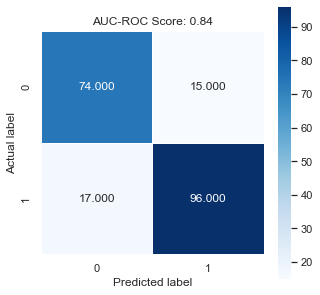

*****************************************************
Validation Set Performance:
*****************************************************
Accuracy of KNN : 0.81
ROC AUC Score of KNN : 0.81
Confusion Matrix of KNN : 



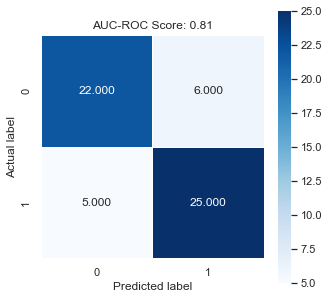

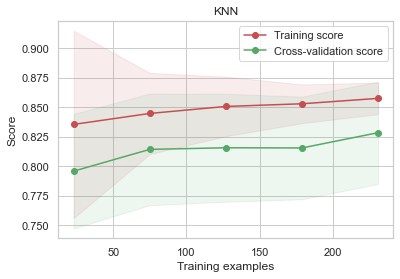

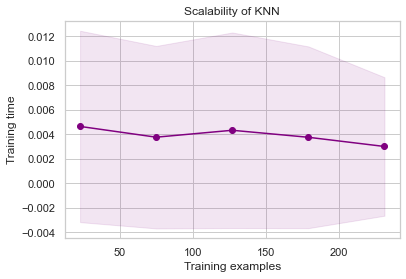

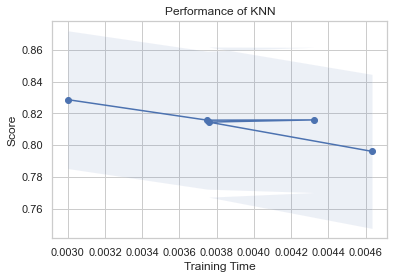

In [50]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=7)

ml_model(knn, 'KNN', x_train = x_train, x_valid = x_valid, y_train =  y_train.values.ravel(), y_valid = y_valid.values.ravel(), x_test = None)

generate_learning_curves(
    model = knn, 
    model_name = "KNN", 
    X = input_data,
    y = targets,
    epochs=4)

Slight overfitting, but the model might have some high bias.

#### Hyper-parameter tuning

In [51]:
def KNNGridSearch(X, y, param_limits):
    '''
    KNN - Grid Search Method
    '''    
    param_grid = {
                  'n_neighbors': param_limits[0],
                  'algorithm': param_limits[1],
                  'leaf_size' : param_limits[2]
                 }

    knn = GridSearchCV(estimator = KNeighborsClassifier(),
                       param_grid=param_grid, 
                       cv=10)
    
    knn.fit(X, y)
    print("Best SVM Hyper-Parameters are:")
    print(knn.best_params_)
    
    return knn.best_params_['n_neighbors'], knn.best_params_['algorithm'], knn.best_params_['leaf_size']

In [52]:
n_neighbors = list(range(1,20))
algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']
leaf_size = list(range(5,50,5))

best_n_neighbors, best_algorithm, best_leaf_size = KNNGridSearch(x_train,  y_train.values.ravel(), (n_neighbors, algorithm, leaf_size))

Best SVM Hyper-Parameters are:
{'algorithm': 'auto', 'leaf_size': 5, 'n_neighbors': 12}


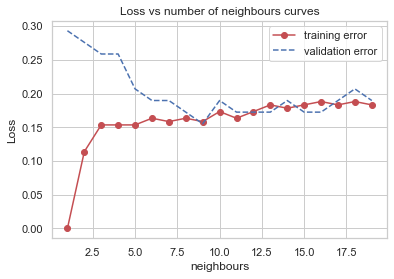

In [53]:
train=[]
valid=[]
for i in range(1,20):
    knn = KNeighborsClassifier(n_neighbors=i, leaf_size = best_leaf_size, algorithm = best_algorithm)
    knn.fit(x_train, y_train.values.ravel())
    train.append(1- accuracy_score(knn.predict(x_train), y_train.values.ravel()))
    valid.append(1- accuracy_score(knn.predict(x_valid), y_valid.values.ravel()))

plt.title('Loss vs number of neighbours curves')
num_estimators=[i for i in range(1,20)]
plt.plot(num_estimators, train,'o-', color = 'r', label = 'training error')
plt.plot(num_estimators, valid, '--', color = 'b', label = 'validation error')
plt.xlabel('neighbours')
plt.ylabel('Loss')
plt.legend()
plt.show()

choosing 9 neighbours from the loss curve as validation loss is lowest at n = 9

*****************************************************
Training Set Performance:
*****************************************************
Accuracy of KNN : 0.84
ROC AUC Score of KNN : 0.84
Confusion Matrix of KNN : 



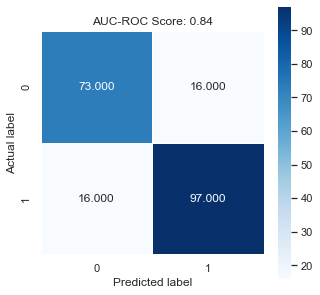

*****************************************************
Validation Set Performance:
*****************************************************
Accuracy of KNN : 0.84
ROC AUC Score of KNN : 0.84
Confusion Matrix of KNN : 



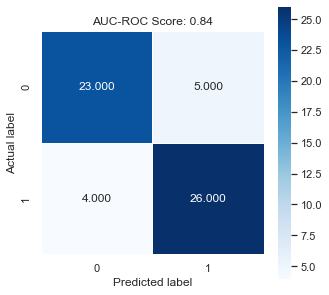

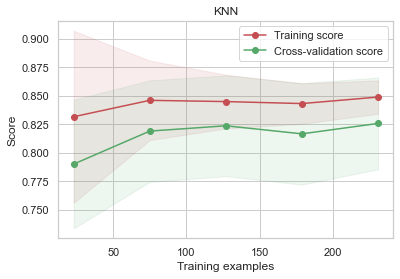

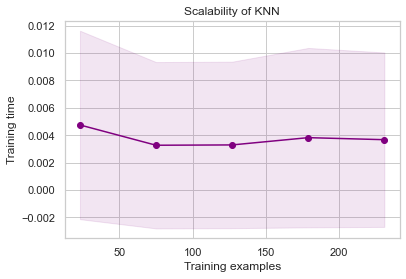

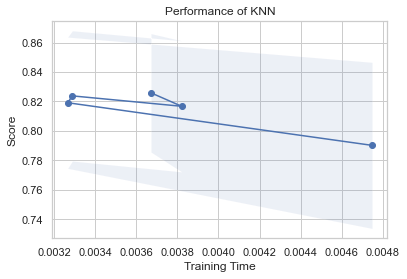

In [54]:
tuned_knn = KNeighborsClassifier(n_neighbors=9, leaf_size = best_leaf_size, algorithm = best_algorithm)

ml_model(tuned_knn, 'KNN', x_train = x_train, x_valid = x_valid, y_train =  y_train.values.ravel(), y_valid = y_valid.values.ravel(), x_test = None)

generate_learning_curves(
    model = tuned_knn, 
    model_name = "KNN", 
    X = input_data,
    y = targets,
    epochs=4)

No significant over-fitting, but the model seems to have under-fitting and high bias. But the model may be generalized after the hyper-parameter tuning process.

## Section 5 : Model Performance on Test Data

For the tuned Decision Tree model :

*****************************************************
Test Set Performance:
*****************************************************
Model Time Complexity on Test Data: 3.004 milli seconds
Accuracy of tuned Decision Tree : 0.79
ROC AUC Score of tuned Decision Tree : 0.81
Confusion Matrix of tuned Decision Tree : 



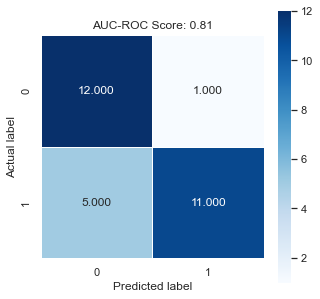

For the tuned MLP Neural Network model :

*****************************************************
Test Set Performance:
*****************************************************
Model Time Complexity on Test Data: 1.001 milli seconds
Accuracy of tuned Neural Network : 0.90
ROC AUC Score of tuned Neural Network : 0.91
Confusion Matrix of tuned Neural Network : 



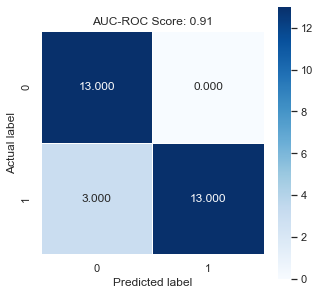

For the tuned ADA Boost model :

*****************************************************
Test Set Performance:
*****************************************************
Model Time Complexity on Test Data: 5.000 milli seconds
Accuracy of tuned ADA Boost : 0.97
ROC AUC Score of tuned ADA Boost : 0.97
Confusion Matrix of tuned ADA Boost : 



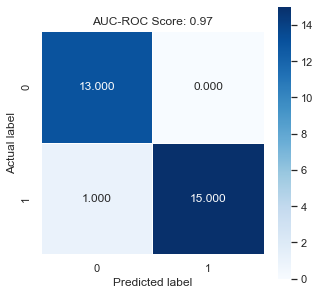

For the tuned SVM model :

*****************************************************
Test Set Performance:
*****************************************************
Model Time Complexity on Test Data: 0.000 milli seconds
Accuracy of tuned SVM : 0.97
ROC AUC Score of tuned SVM : 0.97
Confusion Matrix of tuned SVM : 



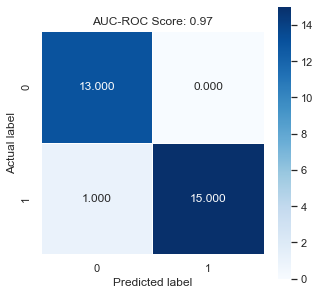

For the tuned KNN model :

*****************************************************
Test Set Performance:
*****************************************************
Model Time Complexity on Test Data: 2.997 milli seconds
Accuracy of tuned KNN : 0.90
ROC AUC Score of tuned KNN : 0.91
Confusion Matrix of tuned KNN : 



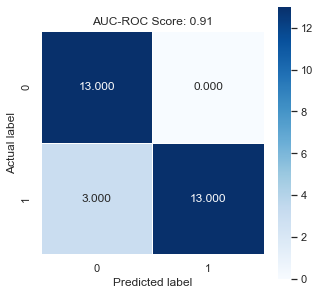

In [55]:
from joblib import dump

print('For the tuned Decision Tree model :\n')
ml_model(tuned_DTC, 'tuned Decision Tree', x_train = None, x_valid = None, x_test = x_test, y_test = y_test.values.ravel() )

print('For the tuned MLP Neural Network model :\n')
ml_model(tuned_NN, 'tuned Neural Network', x_train = None, x_valid = None, x_test = x_test, y_test = y_test.values.ravel() )

print('For the tuned ADA Boost model :\n')
ml_model(tuned_adaBoost, 'tuned ADA Boost', x_train = None, x_valid = None, x_test = x_test, y_test = y_test.values.ravel() )
dump(tuned_adaBoost, "aditya_model1_adaboost.joblib")

print('For the tuned SVM model :\n')
ml_model(tuned_svc, 'tuned SVM', x_train = None, x_valid = None, x_test = x_test, y_test = y_test.values.ravel() )
dump(tuned_svc, "aditya_model2_svm.joblib")

print('For the tuned KNN model :\n')
ml_model(tuned_knn, 'tuned KNN', x_train = None, x_valid = None, x_test = x_test, y_test = y_test.values.ravel() )


### Conclusion

With a model score of 0.97 on test data and considering time complexity and model scores, we see SVM performs the best for all the tuned models. If there is not restriction on the model execution time, I would prefer going with ADABoost as if we compare the tuned model performance on both validation and test set, ADABoost showed better results than SVM. 

The reason why ADABoost is slower because since it is an ensemble model and based of the size of the number estimators, the model is believed to take much more time than SVM. 

Another common observation from confusion matrix over the test data, is related to false negatives. The false negative counts is higher than false postives for almost all the models. Considering this problem is related to the medical domain, where false negative can be more costly than false positives, I would say that the best perfroming tuned models would be acceptable to solve such a problem scenario.

But almost all tuned model seems to fit quite well on the Test Data apart from Decision Tree and hence shows good generalization on this dataset. Decision Tree on the other hand, slowed almost same scores for Train, Test and Valid data, but it has some amount of bias due to which the model efficiency is not increasing. Training with more data and multiple batch of data samples may help to remove that. Also noisy data is also known to have bias. Overall, we can conclude that the hyper-parameter tuning on ADABoost and SVM produced good fit and generalized model which performed well on the test data.

### Acknowledgements

Kaggle Data Source Link: https://www.kaggle.com/ronitf/heart-disease-uci


Creators of the original dataset:

1. Hungarian Institute of Cardiology. Budapest: Andras Janosi, M.D.
2. University Hospital, Zurich, Switzerland: William Steinbrunn, M.D.
3. University Hospital, Basel, Switzerland: Matthias Pfisterer, M.D.
4. V.A. Medical Center, Long Beach and Cleveland Clinic Foundation: Robert Detrano, M.D., Ph.D.

Donor of origianl dataset:
- David W. Aha (aha '@' ics.uci.edu) (714) 856-8779